In [1]:
import os
from subprocess import check_call
import numpy as np
import xarray as xr

import dask

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
import cmocean

import util

In [2]:
ds = xr.open_dataset("/glade/work/mclong/OAE_efficiency_maps_alltime.nc")
ds

<xarray.Dataset> Size: 710MB
Dimensions:         (nlat: 384, nlon: 320, N_month: 180, season: 4)
Coordinates:
    TLONG           (nlat, nlon) float64 983kB ...
    TLAT            (nlat, nlon) float64 983kB ...
  * N_month         (N_month) int32 720B 0 1 2 3 4 5 ... 174 175 176 177 178 179
  * season          (season) object 32B 'January' 'April' 'July' 'October'
Dimensions without coordinates: nlat, nlon
Data variables:
    OAE_efficiency  (season, N_month, nlat, nlon) float64 708MB ...

In [3]:
eta = ds.OAE_efficiency.isel(N_month=36).sel(season="January")
eta

<xarray.DataArray 'OAE_efficiency' (nlat: 384, nlon: 320)> Size: 983kB
[122880 values with dtype=float64]
Coordinates:
    TLONG    (nlat, nlon) float64 983kB ...
    TLAT     (nlat, nlon) float64 983kB ...
    N_month  int32 4B 36
    season   <U7 28B 'January'
Dimensions without coordinates: nlat, nlon

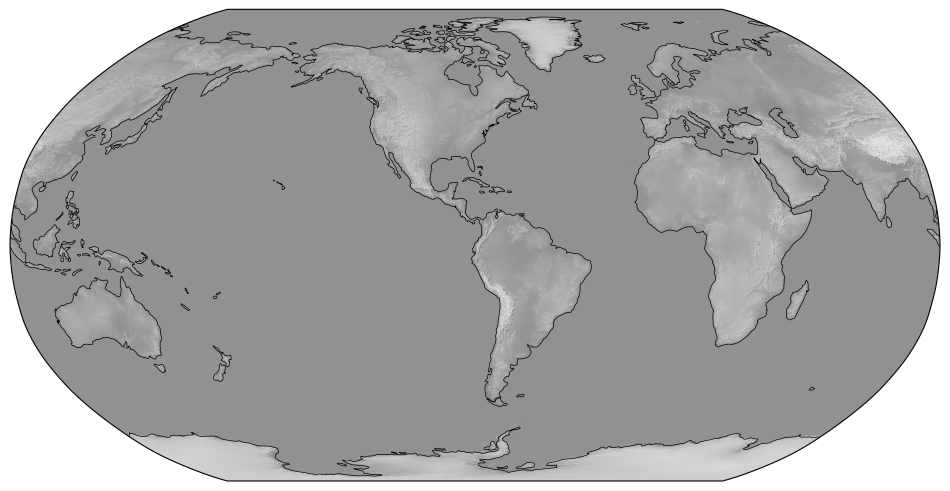

In [10]:
prj = ccrs.Robinson(central_longitude=280)

fig, ax = plt.subplots(
    figsize=(12, 12),
    facecolor="w",
    subplot_kw=dict(projection=prj),
)

# put a background image
ax.background_img("gray-earth-no-ocean", resolution="large4096px")

ax.coastlines(linewidth=0.5)

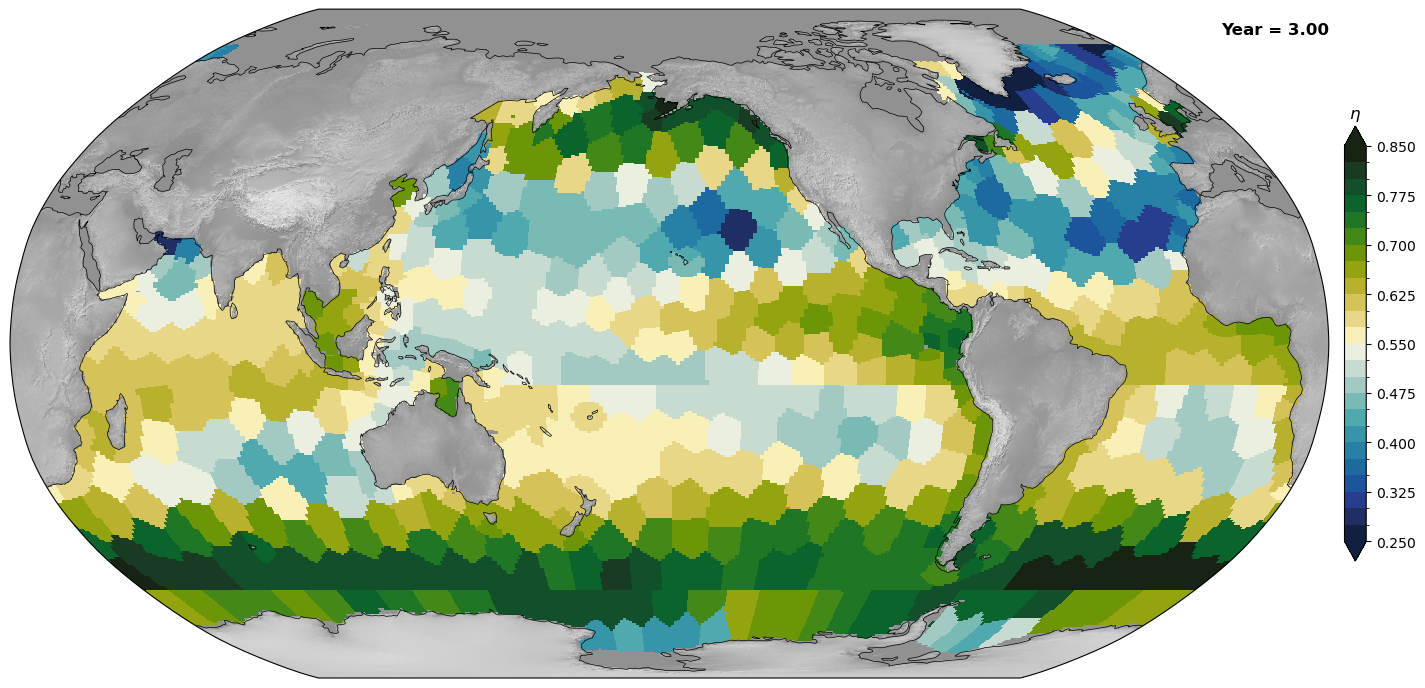

In [4]:
def plot_frame(eta, time_level_movie, diro=None):
    prj = ccrs.Robinson(central_longitude=200, globe=None)

    cmap = cmocean.cm.delta
    dc = 0.025
    levels = np.arange(0.25, 0.85 + dc, dc)

    fig, ax = plt.subplots(
        figsize=(12, 12),
        facecolor="w",
        subplot_kw=dict(projection=prj),
    )

    # put a background image
    ax.background_img("gray-earth-no-ocean", resolution="large4096px")

    ax.coastlines(linewidth=0.5)

    pc = ax.pcolormesh(
        ds.TLONG,
        ds.TLAT,
        eta,
        cmap=cmap,
        norm=colors.BoundaryNorm(levels, ncolors=cmap.N),
        transform=ccrs.PlateCarree(),
    )

    cb = fig.colorbar(pc, shrink=0.5, extend="both", pad=0.01)
    cb.ax.set_title("$\eta$", y=1.05, color="k")

    ax.set_title(
        f"Year = {time_level_movie/12:0.2f}",
        loc="right",
        y=0.95,
        fontweight="bold",
        color="k",
    )

    fig_size = (16, 9)
    fig.set_size_inches(fig_size)
    fig.tight_layout()

    if diro is not None:
        fig.savefig(f"{diro}/{time_level_movie:04d}.png", dpi=300, transparent=True)
        plt.close()


eta = ds.OAE_efficiency.isel(N_month=36).sel(season="January")
plot_frame(eta, 36)

In [5]:
cluster, client = util.get_ClusterClient(memory="12GB")
cluster.scale(60)
client

/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.112:33731,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [2]:
USER = os.environ["USER"]
season = "January"
movie_name = f"OAE-Efficiency-{season}"

diro = f"/glade/work/{USER}/{movie_name}/png"
os.environ["MOVIE_NAME"] = movie_name
os.environ["DIRO"] = diro

In [ ]:
check_call(["rm", "-fr", diro])
os.makedirs(diro, exist_ok=True)


@dask.delayed
def plot_frame_dask(eta, time_level, diro):
    return plot_frame(eta, time_level, diro)


ndx_season = np.where(ds.season == season)[0].item()
del_objs = []
for n in range(1, ds.sizes["N_month"]):
    eta = ds.OAE_efficiency.isel(season=ndx_season, N_month=n)
    del_objs.append(plot_frame_dask(eta, n + 1, diro))

computed_objs = dask.compute(*del_objs)

In [7]:
del client
del cluster

In [3]:
%%bash
MOVOUT=${DIRO}/../${MOVIE_NAME}.mp4
FPS=8
ffmpeg_cmd="ffmpeg -y -start_number 1 -r ${FPS} -i ${DIRO}/%04d.png"
ffmpeg_cmd="${ffmpeg_cmd} -c:v libx264 -pix_fmt yuv420p "
ffmpeg_cmd=${ffmpeg_cmd}' -vf "scale=1440:trunc(ow/a/2)*2" -movflags faststart'

cmd="${ffmpeg_cmd} ${MOVOUT} ;"
echo ${cmd}
eval ${cmd}

ffmpeg -y -start_number 1 -r 8 -i /glade/work/mclong/OAE-Efficiency-January/png/%04d.png -c:v libx264 -pix_fmt yuv420p -vf "scale=1440:trunc(ow/a/2)*2" -movflags faststart /glade/work/mclong/OAE-Efficiency-January/png/../OAE-Efficiency-January.mp4 ;


ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 7 (SUSE Linux)
  configuration: --prefix=///////////////////////////////////////////////////////////////////////////////////////glade/u/apps/casper/23.10/spack/opt/spack/ffmpeg/6.0/gcc/7.5.0/2g5t --enable-pic --cc=/glade/u/apps/casper/23.10/spack/lib/spack/env/gcc/gcc --cxx=/glade/u/apps/casper/23.10/spack/lib/spack/env/gcc/g++ --enable-libxcb --enable-libxcb-shape --enable-libxcb-shm --enable-libxcb-xfixes --enable-xlib --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-bzlib --enable-gpl --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libspeex --enable-libvorbis --enable-libvpx --enable-libx264 --disable-nonfree --disable-openssl --enable-shared --enable-version3 --enable-libzmq --enable-libssh --enable-libwebp --disable-lzma --enable-libsnappy --enable-sdl2 --enable-libaom --enable-libxml2
  libavutil      58.  2.100 / 58.  2.100
  libavcodec     60.  3.100 / 60